In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidian_distances
import json

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

ImportError: cannot import name 'euclidian_distances' from 'sklearn.metrics.pairwise' (D:\Anaconda\envs\pytorch\lib\site-packages\sklearn\metrics\pairwise.py)

In [2]:
# Read CSV file using pandas
credits = pd.read_csv('datasets/tmdb_5000_credits.csv')
movies =  pd.read_csv('datasets/tmdb_5000_movies.csv')
credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [3]:
#Merge tables on "id"
credits.columns = ['id','title','cast','crew']
movies = movies.merge(credits,on='id')

In [4]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [5]:
#mean votes
C = movies['vote_average'].mean()
C

6.092171559442016

In [6]:
#minimum vote score (Keep top 70%)
m = movies['vote_count'].quantile(0.3)
m

76.0

In [7]:
#Keep only 70% top
q_movies = movies
print(q_movies.shape)
q_movies = movies.copy().loc[movies['vote_count'] >= m]
print(q_movies.shape)

(4803, 23)
(3363, 23)


In [9]:
j = json.loads(movies.iloc[0]['genres'])
j

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [10]:
#Merge words
' '.join(''.join(jj['name'].split()) for jj in j)

'Action Adventure Fantasy ScienceFiction'

In [11]:
def genres_keywords_to_string(row):
    genres = json.loads(row['genres'])
    genres = ' '.join(''.join(j['name'].split()) for j in genres)
    
    keywords = json.loads(row['keywords'])
    keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
    return "%s %s" % (genres, keywords)

In [12]:
#apply() applies a function to the dataframe
#create string collumn
movies['string'] = movies.apply(genres_keywords_to_string, axis=1)

In [18]:
#Create tfidf and fit 
#Keeps the most frequent terms, up to 2000 collumns
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(movies['string'])

In [19]:
X

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [17]:
#generate mapping from movie title -> index (in df)
movie2idx = pd.Series(movies.index, index=movies['original_title'])
movie2idx

original_title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [43]:
idx = movie2idx['Avatar']
idx

0

In [44]:
query = X[idx]
query

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [45]:
#print query vector
query.toarray()
#compute similarity between query and every vector in X
scores = cosine_similarity(query,X)
scores.shape

(1, 4803)

(4803,)


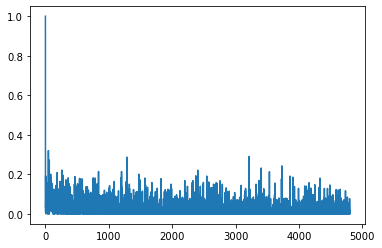

In [46]:
scores = scores.flatten()
print(scores.shape)
plt.plot(scores)

In [ ]:
#sort in descenting order
(-scores).argsort()
plt.plot(scores[(-scores).argsort()])

In [47]:
print((-scores).argsort())

[   0   47 3214 ... 2570 2574 4802]


In [48]:
#get top 5 matches, exclude self
recommended = (-scores).argsort()[1:6]
#convert them to titles again
movies['original_title'].iloc[recommended]

47      Star Trek Into Darkness
3214                 Barbarella
1287         Un monstre à Paris
61            Jupiter Ascending
3730                      Cargo
Name: original_title, dtype: object

In [ ]:
#make it a function